## Cleaning up Atlas data - CNRM/S HistC
**Function**      : Preprocess netCDF files and restructure the dataset<br>
**Description**   : In this notebook serves to clean up Atlas data which is given in netcdf format and aggregate the data into a single file.<br>
**Return Values   : .nc files**<br>
**Note**          : All the data is saved to netCDF4 format. Note that data from different models may vary concerning the resolution and coordinates.<br>

In [1]:
import os
import numpy as np
import xarray as xr
import pandas as pd

### Path
Specify the path to the dataset and the place to save the outputs. <br>

In [3]:
# please specify data path
datapath = './AtlasData/raw'

# please specify output path
output_path = './AtlasData/preprocess'
os.makedirs(output_path, exist_ok = True)

Components used to create the output file names. Here, only `institution_id` and `cmor_var` is based on on CMIP DRS conventions.

In [4]:
output_file_name = {
    "prefix": "atlas",
    "activity": "EUCP", # project name e.g. EUCP
    "institution_id": "CNRM", # CNRM
    "source": "CMIP6", # e.g. CMIP6 or CMIP5
    "method": "HistC", # e.g. HistC
    "sub_method": "cons", # e.g. cons or uncons
    "cmor_var": "tas", # e.g. tas or pr
}

### Load raw data
Extract weather/climate data from given netCDF files.

In [5]:
# CNRM/S HistC DJF
dataset_tas_djf = xr.open_dataset(os.path.join(datapath,'CNRS_HistC',
                          'CNRM_atlas_tas_CMIP6_histssp585_DJF_latlon.nc'))
dataset_tas_djf

<xarray.Dataset>
Dimensions:     (lat: 72, lon: 144)
Coordinates:
  * lat         (lat) float64 -88.75 -86.25 -83.75 -81.25 ... 83.75 86.25 88.75
  * lon         (lon) float64 1.25 3.75 6.25 8.75 ... 351.2 353.8 356.2 358.8
Data variables: (12/15)
    avg_uncons  (lat, lon) float32 ...
    q25_uncons  (lat, lon) float32 ...
    q75_uncons  (lat, lon) float32 ...
    q10_uncons  (lat, lon) float32 ...
    q90_uncons  (lat, lon) float32 ...
    avg_cons    (lat, lon) float32 ...
    ...          ...
    q90_cons    (lat, lon) float32 ...
    avg_diff    (lat, lon) float32 ...
    q25_diff    (lat, lon) float32 ...
    q75_diff    (lat, lon) float32 ...
    q10_diff    (lat, lon) float32 ...
    q90_diff    (lat, lon) float32 ...
Attributes:
    history:  Thu Jul 22 22:36:08 2021: ncpdq -a lat,lon CNRM_atlas_tas_CMIP6...
    NCO:      netCDF Operators version 4.9.2 (Homepage = http://nco.sf.net, C...

In [6]:
# CNRM/S HistC JJA
dataset_tas_jja = xr.open_dataset(os.path.join(datapath,'CNRS_HistC',
                                  'CNRM_atlas_tas_CMIP6_histssp585_JJA_latlon.nc'))
dataset_tas_jja

<xarray.Dataset>
Dimensions:     (lat: 72, lon: 144)
Coordinates:
  * lat         (lat) float64 -88.75 -86.25 -83.75 -81.25 ... 83.75 86.25 88.75
  * lon         (lon) float64 1.25 3.75 6.25 8.75 ... 351.2 353.8 356.2 358.8
Data variables: (12/15)
    avg_uncons  (lat, lon) float32 ...
    q25_uncons  (lat, lon) float32 ...
    q75_uncons  (lat, lon) float32 ...
    q10_uncons  (lat, lon) float32 ...
    q90_uncons  (lat, lon) float32 ...
    avg_cons    (lat, lon) float32 ...
    ...          ...
    q90_cons    (lat, lon) float32 ...
    avg_diff    (lat, lon) float32 ...
    q25_diff    (lat, lon) float32 ...
    q75_diff    (lat, lon) float32 ...
    q10_diff    (lat, lon) float32 ...
    q90_diff    (lat, lon) float32 ...
Attributes:
    history:  Wed Jul 21 16:39:05 2021: ncpdq -a lat,lon CNRM_atlas_tas_CMIP6...
    NCO:      netCDF Operators version 4.9.2 (Homepage = http://nco.sf.net, C...

### Preprocess data

Convert longitudes variables from from 0-360 to -180-180

In [7]:
dataset_tas_djf.coords['lon'] = (dataset_tas_djf.coords['lon'] + 180) % 360 - 180
dataset_tas_djf = dataset_tas_djf.sortby(dataset_tas_djf.lon)

dataset_tas_jja.coords['lon'] = (dataset_tas_jja.coords['lon'] + 180) % 360 - 180
dataset_tas_jja = dataset_tas_djf.sortby(dataset_tas_jja.lon)

Select Europe region

In [8]:
EU_LAT_BNDS = slice(30, 77)
EU_LON_BNDS = slice(-9, 39)

eu_dataset_tas_djf = dataset_tas_djf.sel(lon=EU_LON_BNDS, lat=EU_LAT_BNDS)
eu_dataset_tas_jja = dataset_tas_jja.sel(lon=EU_LON_BNDS, lat=EU_LAT_BNDS)

Create an empty xarray to host the processed data

In [9]:
VAR_NAME = "tas"
TIMES =  {"JJA": "2005-7-16", "DJF": "2005-1-16"} # "0000-4-16", "0000-7-16", "0000-10-16", "0000-1-16" MAM JJA SON DJF
PERCENTILES = [10, 25, 50, 75, 90]

LAT = eu_dataset_tas_djf.coords['lat']
LON = eu_dataset_tas_djf.coords['lon']

ds = xr.Dataset(
                {VAR_NAME: (("time", "latitude", "longitude","percentile"),
                 np.full([len(TIMES), len(LAT), len(LON), len(PERCENTILES)], np.nan)),
                "climatology_bounds": (pd.to_datetime(['2005-6-1', '2005-9-1', '2005-12-1', '2006-3-1']))},
                coords={    
                        "time": pd.to_datetime(list(TIMES.values())),
                        "latitude": LAT.values,
                        "longitude": LON.values, 
                        "percentile": PERCENTILES,
                 },
                 attrs={"description": "Contains modified CNRM/S HistC data used for Atlas in EUCP project.",
                       "history": "original CNRM/S HistC data files CNRM_atlas_tas_CMIP6_histssp585_JJA_latlon.nc, CNRM_atlas_tas_CMIP6_histssp585_DJF.nc" }
)
ds

<xarray.Dataset>
Dimensions:             (time: 2, latitude: 19, longitude: 20, percentile: 5, climatology_bounds: 4)
Coordinates:
  * climatology_bounds  (climatology_bounds) datetime64[ns] 2005-06-01 ... 20...
  * time                (time) datetime64[ns] 2005-07-16 2005-01-16
  * latitude            (latitude) float64 31.25 33.75 36.25 ... 73.75 76.25
  * longitude           (longitude) float64 -8.75 -6.25 -3.75 ... 36.25 38.75
  * percentile          (percentile) int64 10 25 50 75 90
Data variables:
    tas                 (time, latitude, longitude, percentile) float64 nan ....
Attributes:
    description:  Contains modified CNRM/S HistC data used for Atlas in EUCP ...
    history:      original CNRM/S HistC data files CNRM_atlas_tas_CMIP6_hists...

Fix attributes of each variable. Here, we follow CF-conventions as much as possible.

In [10]:
attrs = {"tas" : {"description":"Change in Air Temperature",
            "standard_name":"Change in Air Temperature",
            "long_name": "Change in Near-Surface Air Temperature",
            "units": "K", # in line with raw data
            "cell_methods":"time: mean changes over 20 years 1995-2014",
           },
         "latitude": {"units": "degrees_north", "long_name": "latitude", "axis": "Y"},
         "longitude": {"units": "degrees_east", "long_name": "longitude", "axis": "X"},
         "time": {"climatology": "climatology_bounds",
                  "long_name": "time",
                  "axis": "T",
                  "climatology_bounds": ['2005-6-1', '2005-9-1', '2005-12-1', '2006-3-1'],
                  "description": "20-year climate mean changes over 1995-2014. The mid point 2005 is chosen as the representive time."},
         "percentile": {"units": "%", "long_name": "percentile", "axis": "Z"},
}
                
for key in attrs.keys():
    ds[key].attrs = attrs[key]
    
ds

<xarray.Dataset>
Dimensions:             (time: 2, latitude: 19, longitude: 20, percentile: 5, climatology_bounds: 4)
Coordinates:
  * climatology_bounds  (climatology_bounds) datetime64[ns] 2005-06-01 ... 20...
  * time                (time) datetime64[ns] 2005-07-16 2005-01-16
  * latitude            (latitude) float64 31.25 33.75 36.25 ... 73.75 76.25
  * longitude           (longitude) float64 -8.75 -6.25 -3.75 ... 36.25 38.75
  * percentile          (percentile) int64 10 25 50 75 90
Data variables:
    tas                 (time, latitude, longitude, percentile) float64 nan ....
Attributes:
    description:  Contains modified CNRM/S HistC data used for Atlas in EUCP ...
    history:      original CNRM/S HistC data files CNRM_atlas_tas_CMIP6_hists...

### Assemble data and save to netcdf

Make a function to assemble and save data 

In [11]:
def assembly(ds_original, ds_target, var, season, cons, percentile):
    """
    Select data from original nc files and save the target fields.
    """
    for j, percentile in enumerate(PERCENTILES):
        p = f"q{percentile}"
        if percentile == 50:
            p = "avg"
        ds_target[f"{var}"].values[list(TIMES).index(season),:,:,j] = ds_original[f"{p}_{cons}"]
    

Call the function

In [12]:
output_file_name["cmor_var"] = VAR_NAME 
for projection in ["uncons","cons"]:
    output_file_name["sub_method"] = projection
    
    # DJF
    assembly(eu_dataset_tas_djf, ds, "tas", "DJF", projection, ds.coords["percentile"].values[:])

    # JJA
    assembly(eu_dataset_tas_jja, ds, "tas", "JJA", projection, ds.coords["percentile"].values[:])
    
    file_name = f"{'_'.join(output_file_name.values())}.nc"
    print(f"one dataset is saved to {file_name}")
    ds.to_netcdf(os.path.join(output_path, file_name))

one dataset is saved to atlas_EUCP_CNRM_CMIP6_HistC_uncons_tas.nc
one dataset is saved to atlas_EUCP_CNRM_CMIP6_HistC_cons_tas.nc


### Check output

Load one of the saved data.

In [13]:
ds = xr.open_dataset(os.path.join(output_path,"atlas_EUCP_CNRM_CMIP6_HistC_cons_tas.nc"))
ds

<xarray.Dataset>
Dimensions:             (time: 2, latitude: 19, longitude: 20, percentile: 5, climatology_bounds: 4)
Coordinates:
  * climatology_bounds  (climatology_bounds) datetime64[ns] 2005-06-01 ... 20...
  * time                (time) datetime64[ns] 2005-07-16 2005-01-16
  * latitude            (latitude) float64 31.25 33.75 36.25 ... 73.75 76.25
  * longitude           (longitude) float64 -8.75 -6.25 -3.75 ... 36.25 38.75
  * percentile          (percentile) int64 10 25 50 75 90
Data variables:
    tas                 (time, latitude, longitude, percentile) float64 ...
Attributes:
    description:  Contains modified CNRM/S HistC data used for Atlas in EUCP ...
    history:      original CNRM/S HistC data files CNRM_atlas_tas_CMIP6_hists...

Example: plot temperature of percentile=10 and season JJA

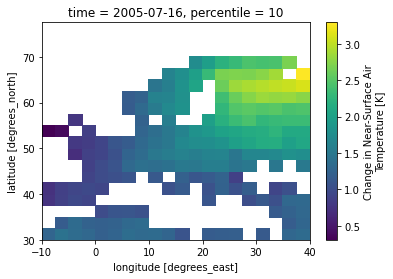

In [14]:
ds.tas.sel(percentile=10).isel(time=0).plot()